https://kskelly03.github.io/

In [83]:
import matplotlib.pyplot as plt
%cd /content
!git clone https://github.com/kskelly03/DataProject.git
%cd /content/DataProject
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import seaborn as sns
pd.set_option('display.max_columns', 500)

/content
fatal: destination path 'DataProject' already exists and is not an empty directory.
/content/DataProject


# Project Goals
Using the pantheon dataset and the biopic dataset, I hope to be able to create an algorithm that can predict the success of a biopic on a given historical figure. This can be used to answer the research question:


> ***In the era of biographical films being made in hollywood, we have seen reenactments of the lives of figures like Elvis Presley, Robert Oppenheimer, Elton John, Whitney Houstion, and Phil Knight have great successes at the Box Office.Given a list of historical figures ranked by popularity, can I predict the success of a biographical film made on that person?***



Why does this matter? In recent years, big budget Hollywood production companies have seemingly begun producing more and more movies reenacting the lives of popular historical figures. If we could predict whether or not a movie on a given figure would be successful at the box office, companies would love to use the model. It would give them added security in the investments they make in production.

# Dataset Descriptions

The first dataset I will be working with is MIT's comprehensive list of famous faces, known as the [Pantheon](https://pantheon.world/data/faq). Pantheon uses Wikipedia entries mined from Wikidata and the English, French, German, Italian, Spanish, Portuguese and Swedish editions of Wikipedia. The dataset comprises of over 2.29 million individuals and is cross-verified. The dataset provides birth dates, gender, citizenship, occupations, and other details. It combines these details with WikiData and their own variables in order to produce HPI, a popular index measuring worldwide popularity score of the given page. The pantheon database has been visited extensively by researchers of all kind.

In [84]:
pantheon = pd.read_csv('pantheon.tsv', sep='\t')
pantheon.head()

,en_curid,name,numlangs,birthcity,birthstate,countryName,countryCode,countryCode3,LAT,LON,continentName,birthyear,gender,occupation,industry,domain,TotalPageViews,L_star,StdDevPageViews,PageViewsEnglish,PageViewsNonEnglish,AverageViews,HPI
0,307,Abraham Lincoln,131,Hodgenville,KY,UNITED STATES,US,USA,37.571111,-85.738611,North America,1809,Male,POLITICIAN,GOVERNMENT,INSTITUTIONS,66145211,5.801387,586914.72200,41477236,24667975,504925.2748,27.938585
1,308,Aristotle,152,Stageira,NaN,Greece,GR,GRC,40.333333,23.500000,Europe,-384,Male,PHILOSOPHER,PHILOSOPHY,HUMANITIES,56355172,11.914597,201067.46070,15745351,40609821,370757.7105,31.993795
2,339,Ayn Rand,55,Saint Petersburg,NaN,Russia,RU,RUS,59.950000,30.300000,Europe,1905,Female,WRITER,LANGUAGE,HUMANITIES,14208218,3.175685,87632.49020,11023490,3184728,258331.2364,24.325936
3,595,Andre Agassi,69,Las Vegas,NV,UNITED STATES,US,USA,36.121514,-115.173851,North America,1970,Male,TENNIS PLAYER,INDIVIDUAL SPORTS,SPORTS,11244030,6.242525,85553.31810,6353888,4890142,162956.9565,20.925999
4,628,Aldous Huxley,62,Godalming,NaN,UNITED KINGDOM,GB,GBR,51.185000,-0.610000,Europe,1894,Male,WRITER,LANGUAGE,HUMANITIES,9268920,6.219842,33037.03209,5137256,4131664,149498.7097,25.996605


The second dataset I will be looking into to answer my research question is a biopic dataset created from wikipedia's [list of biographical films](https://en.wikipedia.org/wiki/List_of_biographical_films), the most updated set of verified biopics I could find. I will be merging this with a [movie dataset](https://www.kaggle.com/datasets/ashishjangra27/imdb-movies-dataset) sourced from IMDb's data collection on movies, complete with an aggregated user rating score from a variety of websites. By merging this with my biopics dataset on movie title I will be able to grab a user rating for every known biopic. Getting all of this lined up was a painstaking but rewarding process that allowed me to have much more up-to-date information.

# Cleaning up the Pantheon

This section involves taking the Pantheon dataset and preforming ETL in order to get the dataset into a digestible format based on the principles of tidy data.

Let's first start by checking out the columns:

In [85]:
pantheon.columns

Index(['en_curid', 'name', 'numlangs', 'birthcity', 'birthstate',
       'countryName', 'countryCode', 'countryCode3', 'LAT', 'LON',
       'continentName', 'birthyear', 'gender', 'occupation', 'industry',
       'domain', 'TotalPageViews', 'L_star', 'StdDevPageViews',
       'PageViewsEnglish', 'PageViewsNonEnglish', 'AverageViews', 'HPI'],
      dtype='object')

We can start by dropping some of the columns that are not important to us, or filled with too many NaN values.

In [86]:
pantheon = pantheon.drop(columns = ["countryCode3", 'birthstate', 'PageViewsEnglish',
                                      'PageViewsNonEnglish', "numlangs"])

Let's also rename the remaining columns to improve readability and make the set easier to perform operations on:

In [87]:
pantheon = pantheon.rename(columns = {'en_curid': 'wiki_id',
                                      'occupation': 'occupation',
                                      'birthyear': 'birth',
                                      'gender': 'gender',
                                      'birthcity': 'city',
                                      'countryName': 'country',
                                      'countryCode': 'country_code',
                                      'continentName': 'continent',
                                      'LAT': 'latitude',
                                      'LON': 'longitude',
                                      'industry': 'industry',
                                      'domain': 'domain',
                                      'TotalPageViews': 'total_page_views',
                                      'StdDevPageViews': 'stdDevPageViews',
                                      'AverageViews': 'average_views',
                                      })

Now, let's update the table to get our most important datapoints first. We can also make some of the entries lowercased in order to look nicer.

In [88]:
pantheon = pantheon.iloc[:,[0, 1, 10, 9, 8, 2, 3, 4, 7, 17, 5, 6, 11, 12, 13, 14, 15, 16]]
def get_lower(entry):
    return entry.lower()
pantheon["occupation"] = pantheon["occupation"].apply(get_lower)
pantheon["industry"] = pantheon["industry"].apply(get_lower)
pantheon["domain"] = pantheon["domain"].apply(get_lower)

In [89]:
pantheon['birth'].replace('', np.nan, inplace=True)

# Remove non-numeric characters and convert to integers
pantheon['birth'] = pantheon['birth'].str.replace(r'\D', '', regex=True)
pantheon['birth'] = pantheon['birth'].replace('', np.nan).astype('Int64')

pantheon.dtypes #dtypes look good

wiki_id               int64
name                 object
occupation           object
gender               object
birth                 Int64
city                 object
country              object
country_code         object
continent            object
HPI                 float64
latitude            float64
longitude           float64
industry             object
domain               object
total_page_views      int64
L_star              float64
stdDevPageViews     float64
average_views       float64
dtype: object

And now, the final reveal

In [90]:
pantheon.head() #much better

,wiki_id,name,occupation,gender,birth,city,country,country_code,continent,HPI,latitude,longitude,industry,domain,total_page_views,L_star,stdDevPageViews,average_views
0,307,Abraham Lincoln,politician,Male,1809,Hodgenville,UNITED STATES,US,North America,27.938585,37.571111,-85.738611,government,institutions,66145211,5.801387,586914.72200,504925.2748
1,308,Aristotle,philosopher,Male,384,Stageira,Greece,GR,Europe,31.993795,40.333333,23.500000,philosophy,humanities,56355172,11.914597,201067.46070,370757.7105
2,339,Ayn Rand,writer,Female,1905,Saint Petersburg,Russia,RU,Europe,24.325936,59.950000,30.300000,language,humanities,14208218,3.175685,87632.49020,258331.2364
3,595,Andre Agassi,tennis player,Male,1970,Las Vegas,UNITED STATES,US,North America,20.925999,36.121514,-115.173851,individual sports,sports,11244030,6.242525,85553.31810,162956.9565
4,628,Aldous Huxley,writer,Male,1894,Godalming,UNITED KINGDOM,GB,Europe,25.996605,51.185000,-0.610000,language,humanities,9268920,6.219842,33037.03209,149498.7097


# Creating and Tidying our Biopics

Now, getting the biopics dataset is going to be a little more complicated. Let's start by using beautiful soup to parse through our website and grab our table of movies.

In [91]:
url = 'https://en.wikipedia.org/wiki/List_of_biographical_films'

# Send a request to the website
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
tables = soup.find_all('table', {'class': 'wikitable'})

# empty list to store dfs
dfs = []

for table in tables:
    df = pd.read_html(str(table))[0]
    dfs.append(df)

wiki_df = pd.concat(dfs, ignore_index=True)

# Drop the 'portrayed by' column
wiki_df = wiki_df.drop(columns=['Portrayed by', 'Lead actor or actress'])
# Also there are a lot of rows with NaN values so we can just drop them since we already have so many movies
wiki_df.dropna(inplace=True)
wiki_df

,Year,Film,Subject(s)
0,1906,The Story of the Kelly Gang,Ned Kelly
1,1909,Origin of Beethoven's Moonlight Sonata,Ludwig van Beethoven
2,1909,The Life of Moses,Moses
3,1909,Saul and David,King David
4,1909,Saul and David,King Saul
...,...,...,...
3288,2024,Untitled Snoop Dogg biopic film,Snoop Dogg
3289,2024,A Complete Unknown,Bob Dylan
3290,2024,Race for Glory: Audi vs. Lancia,Roland Gumpert
3291,2024,Race for Glory: Audi vs. Lancia,Cesare Fiorio


Awesome, every movie has a title, year, and subjects. That's all we need for now. You might notice that these movies go all the way into unreleased 2024 movies, and have multiple subjects. These problems will be addressed as we merge with the IMDb set and then the pantheon, respectively. Let's get our IMDb dataset all set up.

In [92]:
%cd /content
filepath = 'movies.csv'
imdb_movies = pd.read_csv(filepath, low_memory=False, error_bad_lines=False)
imdb_movies= imdb_movies.drop(columns = ['id', 'certificate', "stars_name", 'stars_id', 'description'])
imdb_movies.head()

/content


<ipython-input-92-e13c9e8a1240>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  imdb_movies = pd.read_csv(filepath, low_memory=False, error_bad_lines=False)


,name,year,rating,duration,genre,votes,gross_income,directors_id,directors_name
0,Best in Sex: 2015 AVN Awards,(2015 TV Special),4.0,94 min,"Adult, News",124.0,0,nm1624094,Gary Miller
1,Naughty Novelist,(2008 Video),3.8,88 min,Adult,174.0,0,nm0045256,John Bacchus
2,2011 AVN Awards Show,(2011 TV Special),5.7,83 min,"Adult, News",39.0,0,"nm1624094,nm0754845","Gary Miller,Timothy E. Sabo"
3,Best in Sex: 2017 AVN Awards,(2017 TV Special),4.9,87 min,"Adult, News",225.0,0,nm1624094,Gary Miller
4,AVN Awards 2014,(2014 TV Special),6.7,82 min,"Adult, News",101.0,0,nm1624094,Gary Miller


After checking the datatypes, we have a lot of objects that should be floats, but we will deal with those in a second. For now, we want to convert year to just a column with the release year, so we can merge.

In [93]:
imdb_movies['release_year'] = imdb_movies['year'].str.extract(r'(\d{4})', expand=False)
imdb_movies.drop(columns = ['year'], inplace = True)
imdb_movies.rename(columns = {'name':'title'}, inplace= True)
imdb_movies.head()

,title,rating,duration,genre,votes,gross_income,directors_id,directors_name,release_year
0,Best in Sex: 2015 AVN Awards,4.0,94 min,"Adult, News",124.0,0,nm1624094,Gary Miller,2015
1,Naughty Novelist,3.8,88 min,Adult,174.0,0,nm0045256,John Bacchus,2008
2,2011 AVN Awards Show,5.7,83 min,"Adult, News",39.0,0,"nm1624094,nm0754845","Gary Miller,Timothy E. Sabo",2011
3,Best in Sex: 2017 AVN Awards,4.9,87 min,"Adult, News",225.0,0,nm1624094,Gary Miller,2017
4,AVN Awards 2014,6.7,82 min,"Adult, News",101.0,0,nm1624094,Gary Miller,2014


Now let's merge these two massive datasets to get a little bit more reasonable and usable dataset for our purposes. The moment you've been waiting for.

In [94]:
wiki_df.rename(columns={'Year': 'release_year', 'Film': 'title'}, inplace=True)
imdb_movies = imdb_movies.dropna(subset=['release_year'])
imdb_movies['release_year'] = imdb_movies['release_year'].astype(int)
biopics = pd.merge(imdb_movies, wiki_df, on=['release_year', 'title'], how='inner')
biopics

,title,rating,duration,genre,votes,gross_income,directors_id,directors_name,release_year,Subject(s)
0,The Staircase,7.2,519 min,"Biography, Crime, Drama","14,542",0,Anonymous,nm0000000,2022,Michael Peterson
1,The Staircase,7.2,519 min,"Biography, Crime, Drama","14,542",0,Anonymous,nm0000000,2022,Kathleen Peterson
2,The Staircase,11.0,0 min,"Short, Mystery, Thriller",0,0,nm13631287,SreeramSivanand,2022,Michael Peterson
3,The Staircase,11.0,0 min,"Short, Mystery, Thriller",0,0,nm13631287,SreeramSivanand,2022,Kathleen Peterson
4,House of Gucci,6.6,158 min,"Crime, Drama","108,469","57,300,000",nm0000631,Ridley Scott,2021,Patrizia Reggiani
...,...,...,...,...,...,...,...,...,...,...
2240,Seine einzige Liebe,11.0,0 min,"Biography, Drama",0,0,nm0361518,Emmerich Hanus,1947,Franz Schubert
2241,Docteur Laennec,6.4,95 min,"Biography, Drama",23,0,nm0166996,Maurice Cloche,1949,René Laennec
2242,Rasputín,11.0,0 min,Biography,0,0,nm2466657,Ernesto Mas,1958,Grigori Rasputin
2243,Why America Will Win,11.0,70 min,"Biography, Drama",0,0,nm0822801,Richard Stanton,1918,John J. Pershing


Voila, now lets just get our date types correct, and rearrange some columns.

In [95]:
def convert_income_to_numeric(income):
    if ',' in income:
        income = income.replace(',', '')  # Remove commas if present

    if income.endswith('M'):
        return float(income.replace('$', '').replace('M', '')) * 1e6
    elif income.endswith('K'):
        return float(income.replace('$', '').replace('K', '')) * 1e3
    else:
        return float(income.replace('$', ''))

# Apply the function to convert gross_income to numeric
biopics['gross_income'] = biopics['gross_income'].apply(convert_income_to_numeric)


# Convert votes to integer
biopics['votes'] = biopics['votes'].apply(convert_income_to_numeric)

In [96]:
biopics = biopics.rename(columns ={"Subject(s)": "subject"})
biopics = biopics[['title', 'rating', 'release_year', 'subject', 'votes', 'gross_income', 'duration', 'genre', 'directors_name', 'directors_id']]
display(biopics.head())
print(biopics.dtypes) #Awesome
len(biopics)

,title,rating,release_year,subject,votes,gross_income,duration,genre,directors_name,directors_id
0,The Staircase,7.2,2022,Michael Peterson,14542.0,0.0,519 min,"Biography, Crime, Drama",nm0000000,Anonymous
1,The Staircase,7.2,2022,Kathleen Peterson,14542.0,0.0,519 min,"Biography, Crime, Drama",nm0000000,Anonymous
2,The Staircase,11.0,2022,Michael Peterson,0.0,0.0,0 min,"Short, Mystery, Thriller",SreeramSivanand,nm13631287
3,The Staircase,11.0,2022,Kathleen Peterson,0.0,0.0,0 min,"Short, Mystery, Thriller",SreeramSivanand,nm13631287
4,House of Gucci,6.6,2021,Patrizia Reggiani,108469.0,57300000.0,158 min,"Crime, Drama",Ridley Scott,nm0000631


title              object
rating            float64
release_year        int64
subject            object
votes             float64
gross_income      float64
duration           object
genre              object
directors_name     object
directors_id       object
dtype: object


2245

# Let's Look Into Our Data

For a quick warmup with the data, we can explore the pantheon dataset. How about we use the HPI score to figure out the most popular basketball players on wikipedia.

In [97]:
players = pantheon[pantheon['occupation'] == 'basketball player']
players.set_index('HPI', inplace = True)
players.sort_index(ascending = False, inplace = True)
players.head()

<ipython-input-97-3dd6a2f284ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players.sort_index(ascending = False, inplace = True)


,wiki_id,name,occupation,gender,birth,city,country,country_code,continent,latitude,longitude,industry,domain,total_page_views,L_star,stdDevPageViews,average_views
HPI,,,,,,,,,,,,,,,,,
23.841241,16899,Kareem Abdul-Jabbar,basketball player,Male,1947,New York,UNITED STATES,US,North America,40.712700,-74.005900,team sports,sports,11460425,4.429107,62602.57056,260464.2045
23.815956,255645,Wilt Chamberlain,basketball player,Male,1936,Philadelphia,UNITED STATES,US,North America,39.950000,-75.166667,team sports,sports,10629180,3.555347,69520.05013,241572.2727
23.619816,20455,Michael Jordan,basketball player,Male,1963,New York,UNITED STATES,US,North America,40.692778,-73.990278,team sports,sports,49879093,5.077657,262167.12810,665054.5733
22.403537,36753,Magic Johnson,basketball player,Male,1959,Lansing,UNITED STATES,US,North America,42.733611,-84.546667,team sports,sports,16987222,4.048427,90796.03641,320513.6226
21.838553,412214,Bill Russell,basketball player,Male,1934,West Monroe,UNITED STATES,US,North America,32.510833,-92.140000,team sports,sports,4944312,2.840501,48678.49348,159493.9355


In [98]:
players = pantheon[pantheon['occupation'] == 'basketball player']
players['HPI'].mean()

17.604417681971828

So it looks like the top 5 most popular basketball players on wikipedia are Kareem the Dream, Wilt, Jordan, Magic, and Bill Russell. What a starting 5 that would be. Additionally, we found that basketball players have a mean HPI score of 17.6.

In [99]:
mathies = pantheon[pantheon['occupation'] == 'mathematician']
mathies['HPI'].mean()

24.06658977630573

Comparing that score with mathematicians, we can see that the average mathematician is 7 points more popular on wikipedia. Of course, we already knew that the average mathematician was cooler than the average basketball player, but it's good to have confirmation

# Historical Popularity (HPI) Histogram
For our first visualization, we can create a histogram showing the frequency distribution of the HPI statistic, as we did early on in this class

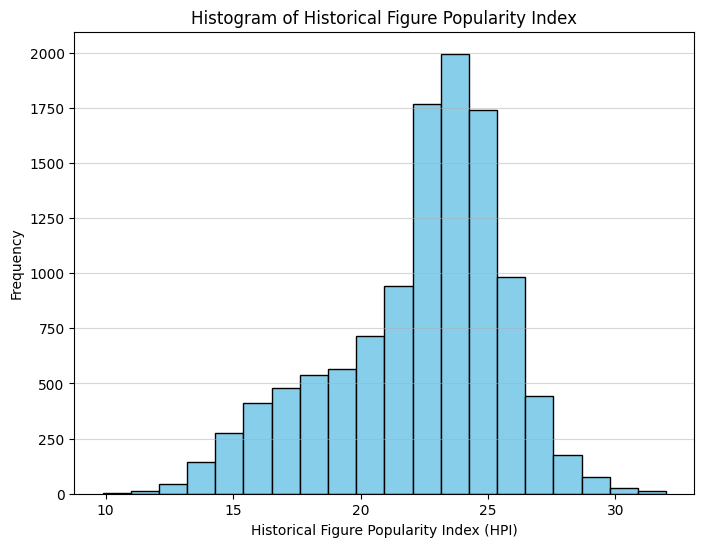

In [100]:
plt.figure(figsize=(8, 6))
plt.hist(pantheon['HPI'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Historical Figure Popularity Index (HPI)')
plt.ylabel('Frequency')
plt.title('Histogram of Historical Figure Popularity Index')
plt.grid(axis='y', alpha=0.5)
plt.show()

As we can see here, the frequency has a left skew, with a median HPI falling somewhere around 24.5

# Biopic vs. Release Year
Secondly, we can plot a line chart showing the count of biopics over different release years. However, we want to investigate the percieved uptick in biopics that people are always complaining about. To do this we will go back to our imdb dataset and normalize the counts by years so we can investigate whether or not we are seeing a disproportionate amount of biopics to the amount of movies in recent years.

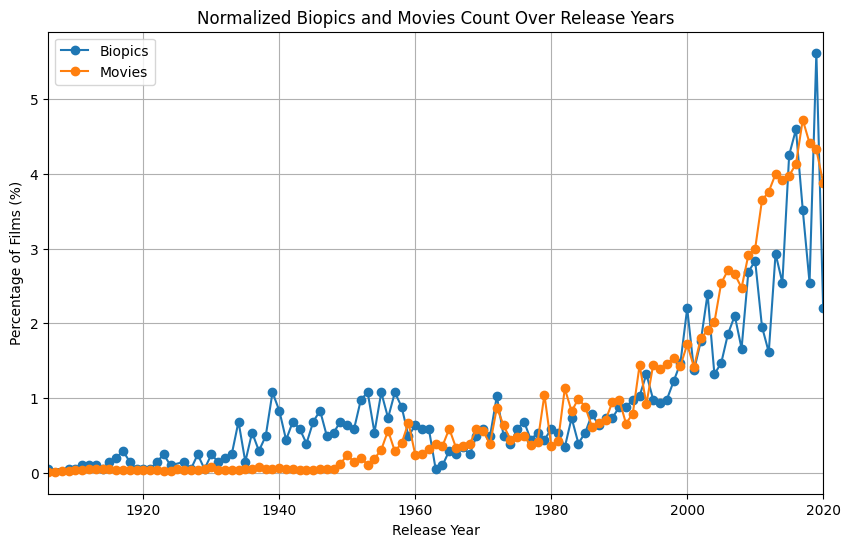

In [101]:
biopics_release_years = biopics['release_year'].value_counts().sort_index()
movies_release_years = imdb_movies['release_year'].value_counts().sort_index()

# Filter data up to the year 2020
biopics_release_years_filtered = biopics_release_years[biopics_release_years.index <= 2020]
movies_release_years_filtered = movies_release_years[movies_release_years.index <= 2020]

# Normalize the counts
biopics_normalized = (biopics_release_years_filtered / biopics_release_years_filtered.sum()) * 100
movies_normalized = (movies_release_years_filtered / movies_release_years_filtered.sum()) * 100

plt.figure(figsize=(10, 6))
plt.plot(biopics_normalized.index, biopics_normalized.values, marker='o', linestyle='-', label='Biopics')
plt.plot(movies_normalized.index, movies_normalized.values, marker='o', linestyle='-', label='Movies')
plt.xlabel('Release Year')
plt.ylabel('Percentage of Films (%)')
plt.title('Normalized Biopics and Movies Count Over Release Years')
plt.legend()
plt.grid(True)
plt.xlim(left=min(biopics_normalized.index), right=2020)  # Limit x-axis to 2020
plt.show()


Interesting, the two graphs follow extremely similar trends. This means that even though the amount of biopics is going up, its not going up any faster than the amount of movies per year. This trend may be different for larger, box office productions, however...

# Distribution of Rating for Biopics
We can also use seaborn to create a boxplot detailing the ratings column for our biopics. Of course, the values of 0.0 are NaN values, so we can ignore them in this metric to produce the most reliable voter score. After we do this, we can see the average score seems to predictably fall around 6.5-7.

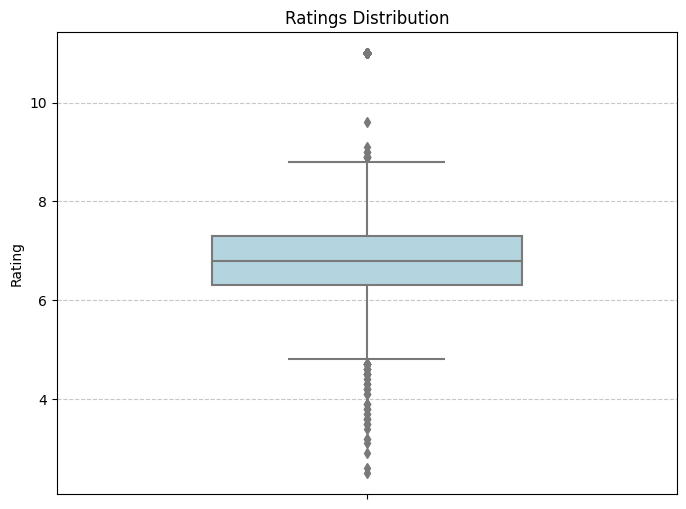

In [102]:
# Filter out ratings of 0.0
filtered_biopics = biopics[biopics['rating'] != 0.0]

plt.figure(figsize=(8, 6))
sns.boxplot(y='rating', data=filtered_biopics, orient='v', color='lightblue', width=0.5)
plt.ylabel('Rating')
plt.title('Ratings Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

How about we look at the lowest rated movie (that's not rated 0.0).

In [103]:
lowest = filtered_biopics['rating'].min()
lowest_rated_movie = filtered_biopics[filtered_biopics['rating'] == lowest]
lowest_rated_movie

,title,rating,release_year,subject,votes,gross_income,duration,genre,directors_name,directors_id
2132,Dream of Love,2.5,1928,Adrienne Lecouvreur,187.0,0.0,65 min,"Biography, Drama",Fred Niblo,nm0629243


Yikes, 187 votes coming into a 2.6 rating. I wouldn't watch Britney Spears's Biopic if I were you.

# Creating a Scatterplot for HPI and rating

In this section we will explore a scatterplot to view the relationships between different HPI and rating. To do this, we have to start by merging the pantheon and the biopics.

In [104]:
merged_df = pd.merge(pantheon, biopics, left_on='name', right_on='subject', how='inner')
merged_df.head()

,wiki_id,name,occupation,gender,birth,city,country,country_code,continent,HPI,latitude,longitude,industry,domain,total_page_views,L_star,stdDevPageViews,average_views,title,rating,release_year,subject,votes,gross_income,duration,genre,directors_name,directors_id
0,307,Abraham Lincoln,politician,Male,1809,Hodgenville,UNITED STATES,US,North America,27.938585,37.571111,-85.738611,government,institutions,66145211,5.801387,586914.722,504925.2748,Young Mr. Lincoln,7.5,1939,Abraham Lincoln,8323.0,73236.0,100 min,"Biography, Drama, History",John Ford,nm0000406
1,307,Abraham Lincoln,politician,Male,1809,Hodgenville,UNITED STATES,US,North America,27.938585,37.571111,-85.738611,government,institutions,66145211,5.801387,586914.722,504925.2748,Abe Lincoln in Illinois,7.3,1940,Abraham Lincoln,1822.0,2356683.0,110 min,"Biography, Drama, History",John Cromwell,nm0188669
2,307,Abraham Lincoln,politician,Male,1809,Hodgenville,UNITED STATES,US,North America,27.938585,37.571111,-85.738611,government,institutions,66145211,5.801387,586914.722,504925.2748,Lincoln,7.0,1988,Abraham Lincoln,419.0,0.0,188 min,"Drama, History, War",nm0000000,Anonymous
3,307,Abraham Lincoln,politician,Male,1809,Hodgenville,UNITED STATES,US,North America,27.938585,37.571111,-85.738611,government,institutions,66145211,5.801387,586914.722,504925.2748,The Dramatic Life of Abraham Lincoln,5.7,1924,Abraham Lincoln,33.0,0.0,120 min,"Biography, Drama, History",Phil Rosen,nm0005847
4,307,Abraham Lincoln,politician,Male,1809,Hodgenville,UNITED STATES,US,North America,27.938585,37.571111,-85.738611,government,institutions,66145211,5.801387,586914.722,504925.2748,The Lincoln Cycle,11.0,1917,Abraham Lincoln,0.0,0.0,0 min,"Biography, Drama, History",John M. Stahl,nm0821472


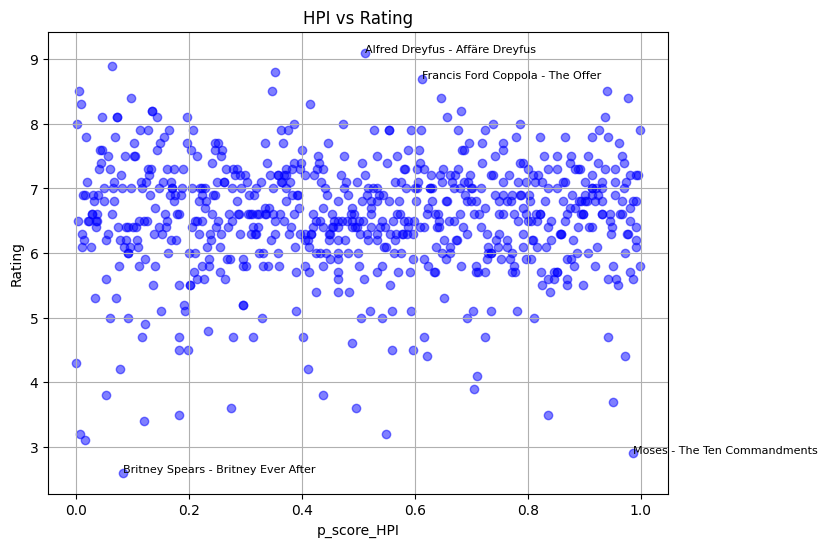

In [105]:
# P-scoring HPI
merged_df['p_score_HPI'] = merged_df['HPI'].rank(pct=True)

# Scatter plot of p_scored HPI vs rating
plt.figure(figsize=(8, 6))
plt.scatter(merged_df[merged_df['rating'] <= 10]['p_score_HPI'], merged_df[merged_df['rating'] <= 10]['rating'], color='blue', alpha=0.5)

top_outliers = merged_df[(merged_df['rating'] > 8.5) & (merged_df['rating'] <= 10)].head(2)  # Select top 2 outliers
bottom_outliers = merged_df[(merged_df['rating'] < 3) & (merged_df['rating'] <= 10)].tail(2)  # Select bottom 2 outliers
selected_outliers = pd.concat([top_outliers, bottom_outliers])

# Labeling outliers on the plot
for i in range(len(selected_outliers)):
    plt.text(selected_outliers.iloc[i]['p_score_HPI'], selected_outliers.iloc[i]['rating'], f"{selected_outliers.iloc[i]['name']} - {selected_outliers.iloc[i]['title']}", fontsize=8)

plt.xlabel('p_score_HPI')
plt.ylabel('Rating')
plt.title('HPI vs Rating')
plt.grid(True)
plt.show()


# Visualizing the Average Gross Income for Pantheon-Figures in Movies

For our last visualization, we will take only the figures with gross income not set to 0 and find the average for each figure in this set. This involves merging some of the pantheon names together using the mean function.

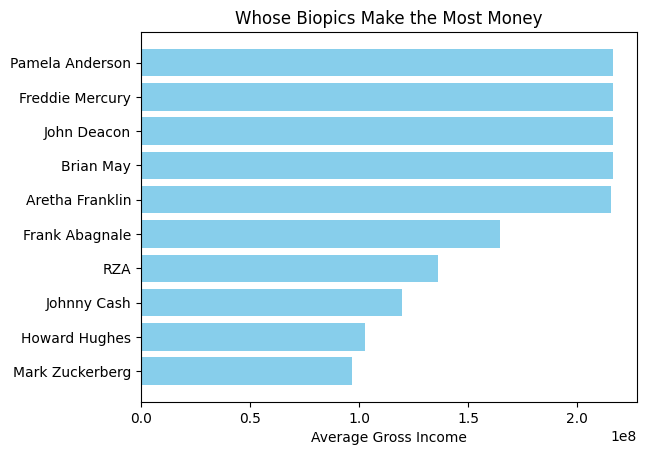

In [135]:
merged_df = pd.merge(pantheon, biopics, left_on='name', right_on='subject', how='inner')
filtered_df = merged_df[(merged_df['gross_income'] != 0)].copy()
avg_ROI_per_figure = filtered_df.groupby('name')['gross_income'].mean().sort_values(ascending=False)

top_10_ROI = avg_ROI_per_figure.head(10)
plt.barh(top_10_ROI.index, top_10_ROI.values, color='skyblue')
plt.xlabel('Average Gross Income')
plt.title('Whose Biopics Make the Most Money')
plt.gca().invert_yaxis()
plt.show()

In this list, we can see the members of Queen from their movie *Bohemian Rhapsody*, or Frank Abagnale from *Catch Me If You Can*.

# Modeling

For the model below, I will be vectorizing the occupation and industry columns. I will also be creating my own HPI calculation representing the p_score for the HPI based on what occupation the historical figure has. Then I will use these numbers, the standard deviation of page views, and the release year to predict if the biopic will be successful. To predict success, I will set my model to guess whether or not the rating will be above average.

In [121]:
merged_df = pd.get_dummies(merged_df, columns=['occupation'], prefix = 'occupation')
occupation_columns = [col for col in merged_df.columns if col.startswith('occupation_')]

def calculate_percentile(group):
    group['HPI_percentile'] = group['HPI'].rank(pct=True)
    return group

merged_df['HPI_percentile'] = merged_df.groupby(occupation_columns)['HPI'].transform(lambda x: x.rank(pct=True))
display(merged_df)
merged_df = pd.get_dummies(merged_df, columns=['industry'], prefix = 'industry')

merged_df.rename(columns ={'HPI_percentile': 'HPI_percentile_occupation'}, inplace = True)

,wiki_id,name,gender,birth,city,country,country_code,continent,HPI,latitude,longitude,industry,domain,total_page_views,L_star,stdDevPageViews,average_views,title,rating,release_year,subject,votes,gross_income,duration,genre,directors_name,directors_id,occupation_actor,occupation_artist,occupation_astronaut,occupation_astronomer,occupation_athlete,occupation_baseball player,occupation_biologist,occupation_boxer,occupation_businessperson,occupation_celebrity,occupation_chef,occupation_chemist,occupation_companion,occupation_composer,occupation_computer scientist,occupation_conductor,occupation_critic,occupation_cyclist,occupation_dancer,occupation_designer,occupation_diplomat,occupation_economist,occupation_engineer,occupation_explorer,occupation_extremist,occupation_fashion designer,occupation_film director,occupation_hockey player,occupation_inventor,occupation_journalist,occupation_lawyer,occupation_mafioso,occupation_magician,occupation_mathematician,occupation_military personnel,occupation_model,occupation_mountaineer,occupation_musician,occupation_nobleman,occupation_painter,occupation_philosopher,occupation_physician,occupation_physicist,occupation_pilot,occupation_pirate,occupation_politician,occupation_pornographic actor,occupation_producer,occupation_psychologist,occupation_public worker,occupation_racecar driver,occupation_religious figure,occupation_sculptor,occupation_singer,occupation_soccer player,occupation_social activist,occupation_writer,HPI_percentile
0,307,Abraham Lincoln,Male,1809,Hodgenville,UNITED STATES,US,North America,27.938585,37.571111,-85.738611,government,institutions,66145211,5.801387,586914.72200,504925.27480,Young Mr. Lincoln,7.5,1939,Abraham Lincoln,8323.0,73236.0,100 min,"Biography, Drama, History",John Ford,nm0000406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.738095
1,307,Abraham Lincoln,Male,1809,Hodgenville,UNITED STATES,US,North America,27.938585,37.571111,-85.738611,government,institutions,66145211,5.801387,586914.72200,504925.27480,Abe Lincoln in Illinois,7.3,1940,Abraham Lincoln,1822.0,2356683.0,110 min,"Biography, Drama, History",John Cromwell,nm0188669,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.738095
2,307,Abraham Lincoln,Male,1809,Hodgenville,UNITED STATES,US,North America,27.938585,37.571111,-85.738611,government,institutions,66145211,5.801387,586914.72200,504925.27480,Lincoln,7.0,1988,Abraham Lincoln,419.0,0.0,188 min,"Drama, History, War",nm0000000,Anonymous,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.738095
3,307,Abraham Lincoln,Male,1809,Hodgenville,UNITED STATES,US,North America,27.938585,37.571111,-85.738611,government,institutions,66145211,5.801387,586914.72200,504925.27480,The Dramatic Life of Abraham Lincoln,5.7,1924,Abraham Lincoln,33.0,0.0,120 min,"Biography, Drama, History",Phil Rosen,nm0005847,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.738095
4,307,Abraham Lincoln,Male,1809,Hodgenville,UNITED STATES,US,North America,27.938585,37.571111,-85.738611,government,institutions,66145211,5.801387,586914.72200,504925.27480,The Lincoln Cycle,11.0,1917,Abraham Lincoln,0.0,0.0,0 min,"Biography, Drama, History",John M. Stahl,nm0821472,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.738095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,63083,Henry Miller,Male,1891,New York,United States,US,North America,25.545865,NaN,NaN,language,humani

Spliiting into training and testing sets

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

occupation_columns = [col for col in merged_df.columns if col.startswith('occupation_')]
industry_columns = [col for col in merged_df.columns if col.startswith('industry_')]

# Original Model without directors_id
X = merged_df[['HPI_percentile_occupation', 'stdDevPageViews', 'release_year']+ occupation_columns + industry_columns]
y = (merged_df['rating'] > merged_df['rating'].mean()).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Feature scaling

In [131]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Model training

In [132]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [133]:
from sklearn.metrics import accuracy_score, classification_report

predictions = knn.predict(X_test_scaled)
binary_predictions = (predictions > 0.5).astype(int)
accuracy = accuracy_score(y_test, binary_predictions)
report = classification_report(y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.6277372262773723
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.65      0.67        80
           1       0.55      0.60      0.57        57

    accuracy                           0.63       137
   macro avg       0.62      0.62      0.62       137
weighted avg       0.63      0.63      0.63       137



Above we have the classification report for the model I created. ... We can also add some visualizations below, such as a pie chart and a confusion matrix

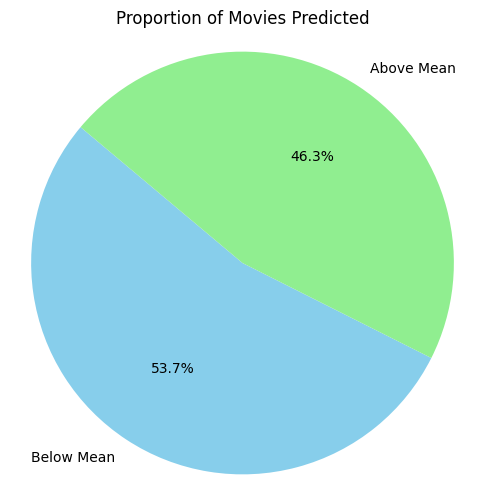

In [126]:
count_0 = sum(binary_predictions == 0)
count_1 = sum(binary_predictions == 1)
counts = [count_0, count_1]
labels = ['Below Mean', 'Above Mean']

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen'])
plt.title('Proportion of Movies Predicted')
plt.axis('equal')
plt.show()



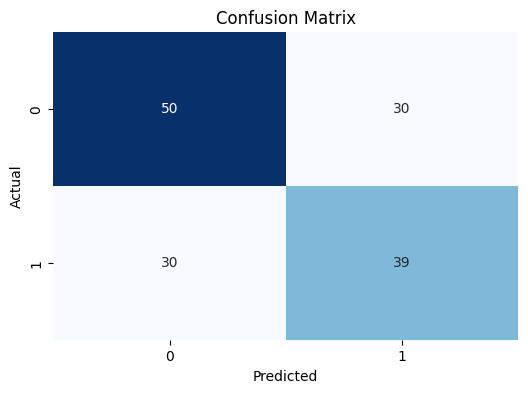

In [127]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(y_test, binary_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Obviously this model is not currently perfect, but it shows some success predicting the outcome of a movie rating with only features from the pantheon dataset. This is a success as far as I was interested in examining the pantheon. I can always refine the model by adding more relevant features. Below I will test adding data on the director

In [129]:
# Trying it with directors_id
label_encoder = LabelEncoder()
occupation_columns = [col for col in merged_df.columns if col.startswith('occupation_')]
industry_columns = [col for col in merged_df.columns if col.startswith('industry_')]
merged_df['directors_id_encoded'] = label_encoder.fit_transform(merged_df['directors_id'])
X = merged_df[['HPI_percentile_occupation', 'stdDevPageViews', 'release_year'] + occupation_columns + industry_columns + ['directors_id_encoded']]
y = (merged_df['rating'] > merged_df['rating'].mean()).astype(int)
merged_df = merged_df[merged_df['directors_id'] != 'Anonymous']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
predictions = knn.predict(X_test_scaled)
binary_predictions = (predictions > 0.5).astype(int)
accuracy = accuracy_score(y_test, binary_predictions)
report = classification_report(y_test, binary_predictions)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.656934306569343
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.74      0.72        80
           1       0.60      0.54      0.57        57

    accuracy                           0.66       137
   macro avg       0.65      0.64      0.64       137
weighted avg       0.65      0.66      0.65       137



Slightly more accurate, with higher precision and recall. I would be interested in putting in budget to this model, it would just require a dataset with slightly more information on it.

# Works Cited

Yu, A. Z., et al. (2016). Pantheon 1.0, a manually verified dataset of globally famous biographies. Scientific Data 2:150075. doi: 10.1038/sdata.2015.75

“List of biographical films” *Wikipedia*, The Wikimedia Foundation, 2 November 2023, https://en.wikipedia.org/wiki/List_of_biographical_films

Ashish Jangra. May 2017. IMDb Movies Dataset, Version 2. Retrieved 16 November 2023 from https://www.kaggle.com/datasets/ashishjangra27/imdb-movies-dataset
